In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

In [2]:
import imageio
from PIL import Image
import napari_animation
import napari
from collections.abc import Iterable

def make_gif_loop(input_path, output_path, color_map_img=None):
    """
    Edits the GIF header to loop indefinitely.
    
    Args:
    input_path (str): Path to the input GIF file.
    output_path (str): Path to save the modified GIF file.
    """
    # try:
    # Open the GIF file using PIL
    with Image.open(input_path) as img:
        # Get the frames and duration
        frames = []
        for i in range(1, img.n_frames):
            img.seek(i)
            frames.append(np.array(img.copy()))
            duration = img.info['duration']
                
        # Save the GIF with loop=0 (infinite loop)
        imageio.mimsave(output_path, frames, duration=duration / 1000, loop=0)
        print(f"GIF saved to {output_path} with infinite loop.")
        
def make_napari_rotation(outpath, viewer, fps=24, duration=5):
    animation = napari_animation.Animation(viewer)

    num_kframes = fps * duration
    steps_per_frame = 1
    for i in range(num_kframes):
        angle = i * (360 / num_kframes)
        viewer.camera.angles = (0, angle, 90)  # Rotate around Y-axis (XZ plane)
        animation.capture_keyframe(steps=steps_per_frame)
        
    viewer.camera.angles = (0, 0, 90)  # Reset camera to original position
    animation.capture_keyframe(steps=steps_per_frame)    
    
    animation.animate(filename='tmp_out.gif', fps=24, scale_factor=1)
    
    make_gif_loop('tmp_out.gif', outpath)
    
def plot_napari(viewer: napari.Viewer, df, column, palette):
    
    if isinstance(palette, Iterable):
        vals = np.nan_to_num(df[column].unique())
    
        color_map = {track: palette[i % 2000] for i, track in enumerate(vals)}
        color = [color_map[track] for track in df[column].fillna(0)]
        
    else:
        color = [palette(val) for val in df[column]]
    
    viewer.add_points(df[["FRAME", "POSITION_X", "POSITION_Y", "POSITION_Z"]], name=column, 
                      properties={"spot id": df.index, column: df[column]},
                      face_color=color, size=13)
    
def tracklet_plot_napari(viewer, tracklets, column, palette, size=8, k=3):
    if isinstance(palette, Iterable):
        vals = np.nan_to_num(tracklets[column].unique())
    
        color_map = {track: palette[i % 2000] for i, track in enumerate(vals)}
        color = [color_map[track] for track in tracklets[column].fillna(0)]
        
    else:
        vals = tracklets[column].values
        val_min = np.median(vals) - k 
        val_max = np.median(vals) + k 
        
        print(f"min: {val_min}, max: {val_max}")
        
        vals_scaled = (vals - val_min) / (val_max - val_min)
        
        color = palette(vals_scaled)
        idx = (vals_scaled > 0) & (vals_scaled < 1)
        
        tracklets = tracklets[idx]
        color = color[idx]
    
    viewer.add_points(tracklets[["x_end", "y_end", "z_end"]], name=column, 
                      properties={"tracklet id": tracklets.index, column: tracklets[column]},
                      face_color=color, size=size, border_color="k", border_width=2, border_width_is_relative=False)
    
    if not isinstance(palette, Iterable):
        # make colormap figure
        fig, ax = plt.subplots()
        ctest = np.linspace(val_min, val_max, 100)
        mpb = plt.scatter(ctest, ctest, c=ctest, cmap=palette, s=1)
        
        fig,ax = plt.subplots()
        plt.colorbar(mpb,ax=ax)
        ax.remove()
        return fig
    

In [3]:
base_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid")
spots_df = pd.read_csv(base_path / "spots.csv")
save_path = base_path / "animated"
save_path.mkdir(exist_ok=True, parents=True)
# spots_df.set_index("ID", inplace=True)

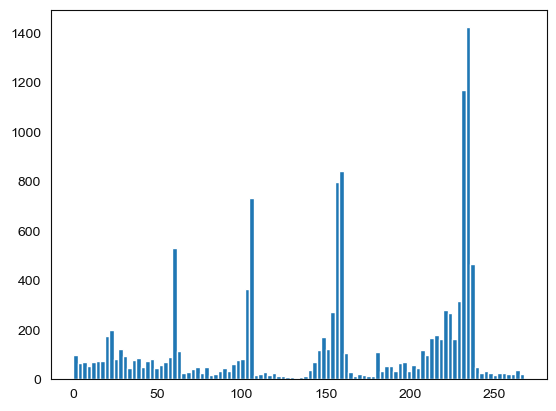

100%|██████████| 259/259 [00:08<00:00, 31.53it/s] 


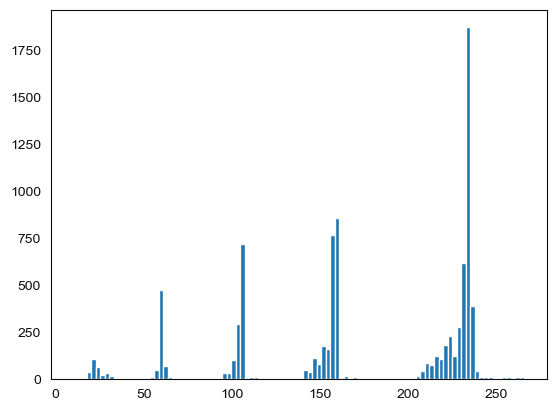

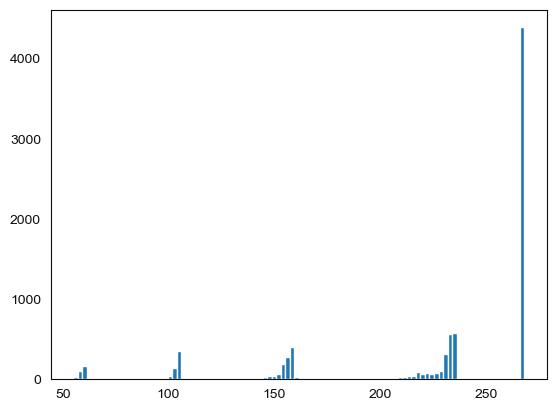

In [4]:
plt.hist(spots_df.groupby("tracklet_id")["FRAME"].min(), bins=100)
plt.show()

cycle_starts = np.array([0, 30, 60, 110, 160, 280])
# cycle_starts = np.array([0, 80, 110, 160, 210, 280])
cycle_starts = np.array([0, 45, 80, 120, 180, 280])

um_per_px = 0.525
spots_df["x"] = spots_df["POSITION_X"] * um_per_px
spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
spots_df["y"] = spots_df["POSITION_Y"] * um_per_px

pos = np.array(spots_df[["x", "y", "z"]])
pca = PCA(n_components=3)  # Choose the number of components you want to keep

transformed_data = pca.fit_transform(pos)
spots_df["AP"] = transformed_data[:, 0]
spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])


spots_df["approx_time"] = spots_df["FRAME"] * (20/60)

t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())

best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

best_spots["local_density"] = 0.0
neighborhood_um = 30

for frame in tqdm(best_spots["FRAME"].unique()):
    frame_spots = best_spots[best_spots["FRAME"] == frame]
    coords = frame_spots[["x", "y", "z"]].values
    dists = cdist(coords, coords)
    close = dists < neighborhood_um
    local_density = 1e6*close.sum(axis=1) / (4/ 3 * neighborhood_um**3 * np.pi)
    best_spots.loc[frame_spots.index, "local_density"] = local_density
    
plt.hist(best_spots.groupby("tracklet_id")["FRAME"].min(), bins=100)
plt.show()

plt.hist(best_spots.groupby("tracklet_id")["FRAME"].max(), bins=100)
plt.show()

In [5]:
def cycle_classifier(time):
    return np.argmax(cycle_starts > time)

tracklets = best_spots.groupby("tracklet_id")
tdf = dict()
tdf["cycle"] =  tracklets["FRAME"].min().apply(cycle_classifier)
tdf["track_id"] = tracklets["track_id"].first()
tdf["time_start"] = tracklets["approx_time"].min()
tdf["time_end"] = tracklets["approx_time"].max()
tdf["cycle_length"] = tdf["time_end"] - tdf["time_start"]
tdf["frame_start"] = tracklets["FRAME"].min()
tdf["frame_end"] = tracklets["FRAME"].max()
tdf["frame_half"] = np.round((tdf["frame_end"] + tdf["frame_start"]) / 2).astype(int)
tdf["x_start"] = tracklets["x"].first()
tdf["y_start"] = tracklets["y"].first()
tdf["z_start"] = tracklets["z"].first()
tdf["AP_start"] = tracklets["AP"].first()
tdf["theta_start"] = tracklets["theta"].first()
tdf["x_end"] = tracklets["x"].last()
tdf["y_end"] = tracklets["y"].last()
tdf["z_end"] = tracklets["z"].last()
tdf["AP_end"] = tracklets["AP"].last()
tdf["theta_end"] = tracklets["theta"].last()
tdf["start_density"] = tracklets["local_density"].first()
tdf["end_density"] = tracklets["local_density"].last()
tdf["median_density"] = tracklets["local_density"].median()
# tdf["parent_tracklet"] = tracklets["parent_id"].first().map(best_spots["tracklet_id"]).fillna(0).astype(int)

tracklets = pd.DataFrame(tdf)
tracklets["track_n_tracklets"] = tracklets["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
tracklets["track_n_tracklets"].value_counts()

spot_pivot = best_spots.pivot_table(index="tracklet_id", columns="FRAME", values="local_density", fill_value=0)
tracklets["half_density"] = [spot_pivot.loc[tracklet_id, frame] for tracklet_id, frame in zip(tracklets.index, tracklets["frame_half"])]

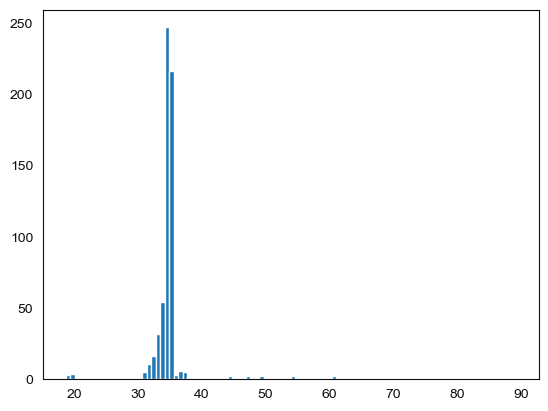

min: 32.166666666666664, max: 37.166666666666664
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 53.42it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\cycle_end_11.gif with infinite loop.


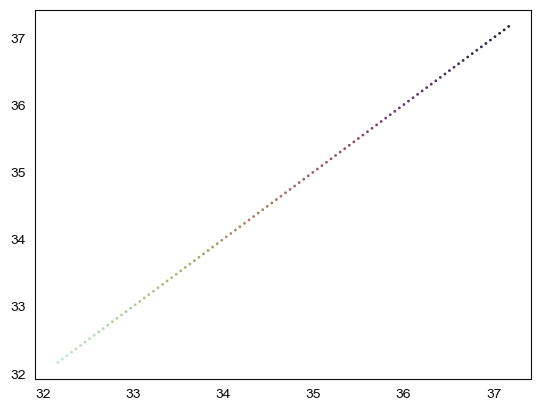

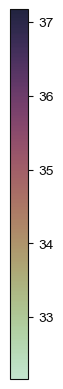

min: 46.33333333333333, max: 58.33333333333333
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 54.60it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\cycle_end_12.gif with infinite loop.


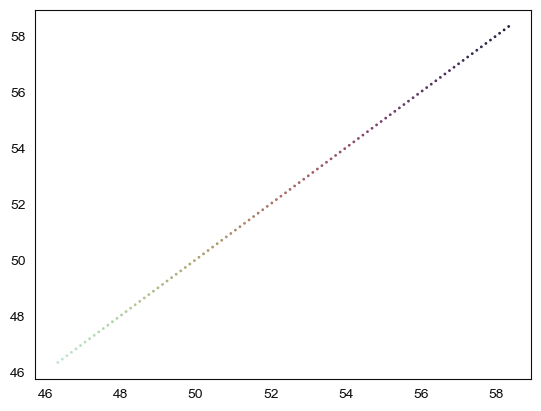

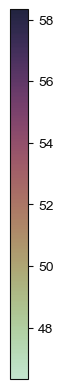

min: 67.33333333333333, max: 87.33333333333333
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 54.41it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\cycle_end_13.gif with infinite loop.


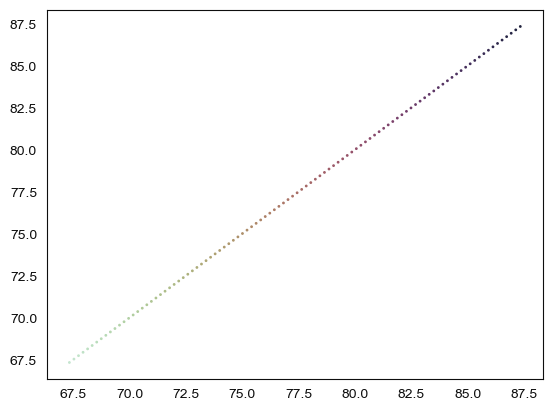

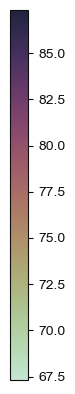

In [6]:

palette = sns.color_palette("cubehelix", as_cmap=True)
palette = sns.cubehelix_palette(start=-.5, rot=1, as_cmap=True)



for cycle, k, s in zip([2, 3, 4], [2.5, 6.0, 10.0], [14, 11, 8]):
    viewer = napari.Viewer(ndisplay=3)
    viewer.theme = "dark"
        
    cycle_tracklets = tracklets[tracklets["cycle"] == cycle]   
    
    plt.hist(cycle_tracklets["time_end"], bins=100)
    plt.show()
    
    tracklet_plot_napari(viewer, cycle_tracklets, "time_end", palette, k=k, size=s)

    fig = make_napari_rotation(save_path / f"cycle_end_{cycle + 9}.gif", viewer, fps=24, duration=5)
    plt.savefig(save_path / f"cycle_end_{cycle + 9}_cbar.png", dpi=300, bbox_inches="tight")
    
# napari.run()

min: 13.419412828830744, max: 163.41941282883073
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 53.36it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\half_density_11.gif with infinite loop.
min: 26.838825657661488, max: 326.83882565766146
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 54.13it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\half_density_12.gif with infinite loop.
min: 147.15182746667375, max: 507.15182746667375
Rendering frames...


100%|██████████| 121/121 [00:02<00:00, 54.47it/s]


GIF saved to D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\animated\half_density_13.gif with infinite loop.


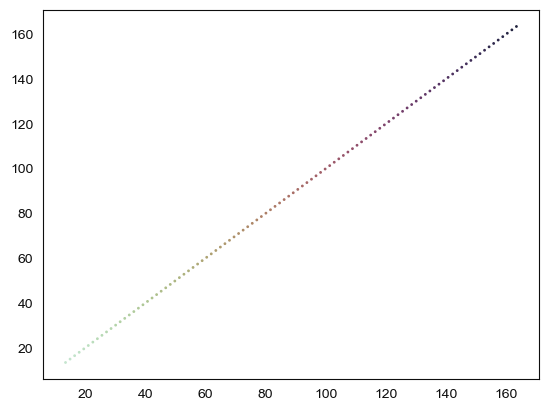

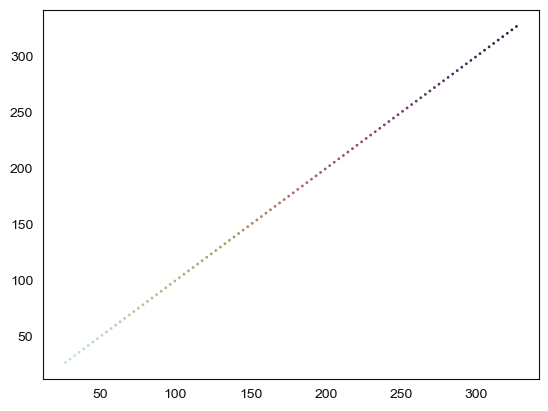

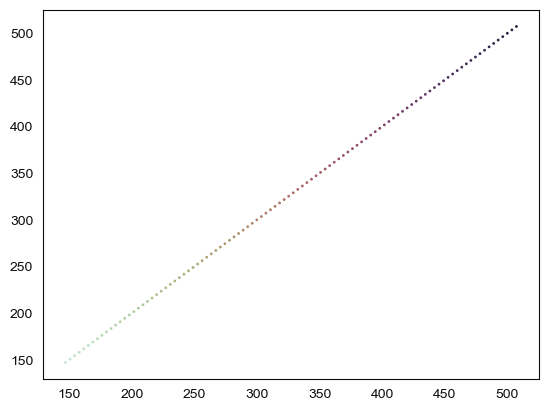

In [7]:
palette = sns.cubehelix_palette(start=-.5, rot=1, as_cmap=True)

for cycle, k, s in zip([2, 3, 4], [75, 150, 180], [14, 11, 8]):
    viewer = napari.Viewer(ndisplay=3)
    viewer.theme = "dark"
    
    cycle_tracklets = tracklets[tracklets["cycle"] == cycle]   
    
    # plt.hist(cycle_tracklets["half_density"], bins=100)
    # plt.show()
    
    tracklet_plot_napari(viewer, cycle_tracklets, "half_density", palette, k=k, size=s)

    fig = make_napari_rotation(save_path / f"half_density_{cycle + 9}.gif", viewer, fps=24, duration=5)
    plt.savefig(save_path / f"half_density_{cycle + 9}_cbar.png", dpi=300, bbox_inches="tight")
    plt.close()

In [8]:
import glasbey

g_palette = glasbey.create_palette(5000, lightness_bounds=(40, 90))

sources = [
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_01_31\recon\out\tracked_spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06\hybrid\spots.csv",
    r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2024_11_04\recon\out\tracked_spots.csv"
]

for i, source in enumerate(sources):

    source_path = Path(source)
    spots_df = pd.read_csv(source_path)
    save_path = Path(r"D:\OneDrive - Princeton University\Lab Meetings\2024_10_21 Toettch")
    # cycle_starts = np.array([0, 30, 60, 110, 160, 280])

    um_per_px = 0.525
    spots_df["x"] = spots_df["POSITION_X"] * um_per_px
    spots_df["z"] = spots_df["POSITION_Z"] * um_per_px
    spots_df["y"] = spots_df["POSITION_Y"] * um_per_px
    
    pos = np.array(spots_df[["x", "y", "z"]])
    pca = PCA(n_components=3)  # Choose the number of components you want to keep
    transformed_data = pca.fit_transform(pos)
    spots_df["AP"] = transformed_data[:, 0]
    spots_df["theta"] = np.arctan2(transformed_data[:, 1], transformed_data[:, 2])
    
    # rotation transformation puts the AP axis in the y direction:
    axes = pca.components_
    rotation_matrix = np.array([axes[1], axes[0], axes[2]])
    pos_rot = pos @ rotation_matrix.T
    spots_df["rotated_x"] = pos_rot[:, 0] - np.min(pos_rot[:, 0])
    spots_df["rotated_y"] = pos_rot[:, 1] - np.min(pos_rot[:, 1])
    spots_df["rotated_z"] = pos_rot[:, 2] - np.min(pos_rot[:, 2])
    
    spots_df["reflection_z"] = -0.2 * spots_df["rotated_z"].max() - spots_df["rotated_z"]
    spots_df["reflection_x"] = spots_df["rotated_x"].max() - spots_df["rotated_x"]
    
    spots_df["is_reflected"] = spots_df["rotated_x"] > (spots_df["rotated_x"].max() / 2 - 10)
    
    spots_df["display_x"] = spots_df["reflection_x"] * spots_df["is_reflected"] + spots_df["rotated_x"] * (
        ~spots_df["is_reflected"])
    spots_df["display_z"] = spots_df["reflection_z"] * spots_df["is_reflected"] + spots_df["rotated_z"] * (
        ~spots_df["is_reflected"])
    
    spots_df["approx_time"] = spots_df["FRAME"] / 3.
    
    t_grouper = spots_df.groupby("tracklet_id")["approx_time"]
    spots_df["cycle_length"] = spots_df["tracklet_id"].map(t_grouper.max()) - spots_df["tracklet_id"].map(t_grouper.min())
    
    best_spots = spots_df[spots_df["track_id"] > 0].copy()
    n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
    best_spots = best_spots[n_tracklets > 1]
    
    final_tids = best_spots.groupby("track_id")["FRAME"].max()[best_spots.groupby("track_id")["FRAME"].max() > best_spots["FRAME"].max() - 10].index
    print(final_tids)
    best_spots = best_spots[best_spots["track_id"].isin(final_tids)]
    
    # np.save(save_path / "tid_colors")
    import napari
    from napari.utils.theme import available_themes, get_theme, register_theme
    
    bg_color = "#000000"
    border_color = "#000000"
    # palette = np.array(["#F2E5D5", "#2B678C", "#1E3E59", "#D9A78B", "#DBE9D8", "#2B678C", "#444444"])

    
    viewer = napari.Viewer(ndisplay=3)
    viewer._canvas_size = (900, 900)

    viewer.theme = "dark"
    
    print(best_spots["FRAME"].max())
    
    sz_start = 13
    sz_end = 5
    f_start = round(best_spots["FRAME"].min())
    f_end = round(best_spots["FRAME"].max())
    sz = np.linspace(sz_start, sz_end, f_end - f_start + 1, endpoint=True)
    sz_map = {frame: size for frame, size in zip(range(f_start, f_end + 1), sz)}
    
    tids = best_spots["track_id"]
    cmap = {tid: i for i, tid in enumerate(np.unique(tids))}
    
    tmppath = save_path / "napari_glasbey"
    tmppath.mkdir(exist_ok=True)
    
    tids = best_spots["track_id"]
    color = [g_palette[cmap[tid]] for tid in tids]
    
    pts = np.array(best_spots[["FRAME", "display_x", "rotated_y", "display_z"]])
    s = [sz_map[frame] for frame in best_spots["FRAME"]]
    
    l = viewer.add_points(pts, border_color=border_color, border_width=0.04,
                              face_color=color, size=s, translate=[100, 0, 0], shading='spherical', antialiasing=0.5)

    # move camera back in z
    

    l.refresh()
    
    animation = napari_animation.Animation(viewer)
    viewer.update_console({"animation": animation})
    # animation.capture_keyframe(steps=1)
    viewer.camera.zoom = 0.95
    
    for frame in tqdm(range(f_end-220, f_end + 1)):
        viewer.dims.set_point(0, frame)
        animation.capture_keyframe(steps=1)
        
    animation.animate(filename=save_path / f"glasbey_tracklets.gif", fps=24, scale_factor=1)
    make_gif_loop(save_path / f"glasbey_tracklets.gif", save_path / f"2{chr(ord('A') + i)}_glasbey_tracklets_loop.gif")

Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       421, 423, 425, 426, 428, 429, 430, 431, 433, 462],
      dtype='int64', name='track_id', length=416)
247.0


100%|██████████| 221/221 [00:49<00:00,  4.45it/s]


Rendering frames...


100%|██████████| 221/221 [00:18<00:00, 11.82it/s]


GIF saved to D:\OneDrive - Princeton University\Lab Meetings\2024_10_21 Toettch\2A_glasbey_tracklets_loop.gif with infinite loop.
Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       385, 386, 387, 388, 389, 390, 391, 392, 393, 394],
      dtype='int64', name='track_id', length=390)
268


100%|██████████| 221/221 [00:47<00:00,  4.61it/s]


Rendering frames...


100%|██████████| 221/221 [00:17<00:00, 12.50it/s]


GIF saved to D:\OneDrive - Princeton University\Lab Meetings\2024_10_21 Toettch\2B_glasbey_tracklets_loop.gif with infinite loop.
Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       597, 666, 730, 757, 790, 871, 898, 899, 926, 956],
      dtype='int64', name='track_id', length=488)
277


100%|██████████| 221/221 [00:46<00:00,  4.71it/s]


Rendering frames...


100%|██████████| 221/221 [00:17<00:00, 12.92it/s]


GIF saved to D:\OneDrive - Princeton University\Lab Meetings\2024_10_21 Toettch\2C_glasbey_tracklets_loop.gif with infinite loop.
